In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2024-08-10 23:24:50.471025: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 23:24:50.471170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 23:24:50.690286: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/fold_3/keras/default/1/model3_fold3.h5
/kaggle/input/drugmechanisms/DOWNLOAD-adHR51GpyZwztvXIVQ3rkc5LgNb7lm3YyO0Bnu7QscE=.tsv
/kaggle/input/fold_2/keras/default/1/model3_fold2.h5
/kaggle/input/fold_5/keras/default/1/model3_fold5.h5
/kaggle/input/chembl22/chembl_22_clean_1576904_sorted_std_final.smi
/kaggle/input/fold_4/keras/default/1/model3_fold4.h5
/kaggle/input/fold1/keras/default/1/model3_fold1.h5


# Drug Design with Small Molecule SMILES

## Introduction

In this project, we will attempt to find out if a machine learning alghoritm can predict medical usage of different chemicals based off of their structure.
### Why is this important?
One of the main usages of computers and machine learning in medicine is drug design and prediction of different drug mechanisms. This is something we couldn't do manually due to complex structure of majority of biochemical molecules. Here, we will start with small molecules to check how accurate model can be produced using simplest methods.

## Data

#### Datasets to be used are the following:



### Drug Design with Small Molecule SMILES - Dataset containing molecules in SMILES format
https://www.kaggle.com/datasets/art3mis/chembl22/data




In [2]:
path1 = '/kaggle/input/chembl22/chembl_22_clean_1576904_sorted_std_final.smi'
data1 = pd.read_csv(path1, sep='\t', header=None)
data1.head()

,0,1
0,CCO,CHEMBL545
1,C,CHEMBL17564
2,CO,CHEMBL14688
3,NCCS,CHEMBL602
4,NCCN,CHEMBL816


Since dataset is well documented, we have the following information about the columns:
 - The first column is the SMILES string.
 - The second is a reference to the full ChEMBL entry for that particular molecule. 


#### What is SMILES?
SMILES stands for “Simplified Molecular Input Line Entry System". 


The purpose of SMILES is to translate the 3D molecular structure of different chemicals into a linear representation of the molecule so that a computer program can understand the structure.


![](https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid=5288826&t=l)

Morphine, shown in picture, has SMILES format Oc1ccc2CC(N3C)C4C=CC(O)C5Oc1c2C45CC3.

##### Visualization
First off, let's start with checking how length of SMILES string behaves within the dataset.

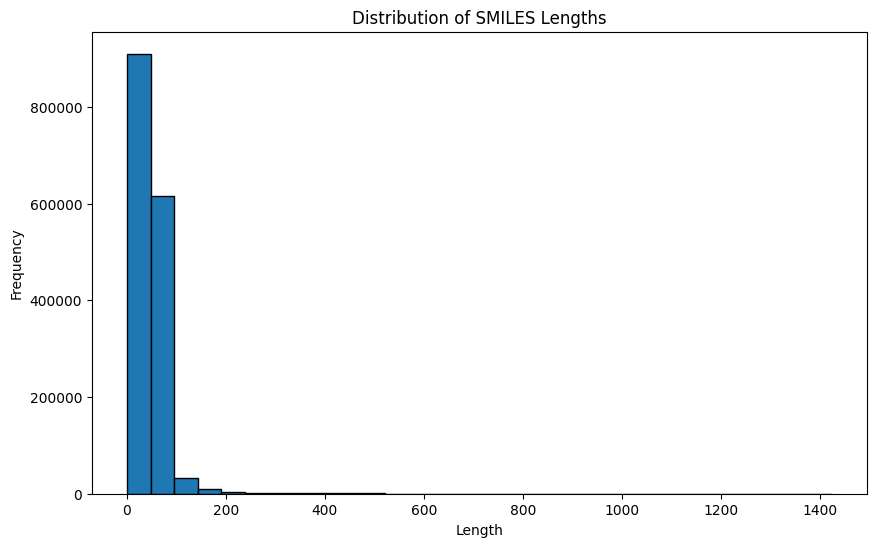

In [3]:
import matplotlib.pyplot as plt
lengths = data1[0].apply(len)
max_length_index = lengths.idxmax()
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, edgecolor='black')
plt.title('Distribution of SMILES Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

As we can see, majority of strings are shorter than 200 characters. Here, it would seem wise to use only the SMILES up to length 200.

In [4]:
max_length = data1[0].apply(len).max()
print(f"The length of the longest element in the first column is: {max_length}")
print(f"That entry is: {data1[0][max_length_index]}")

The length of the longest element in the first column is: 1423
That entry is: CC1=CN(C2CC(OP(O)(=O)OCC3OC(C(O)C3OP(O)(=O)OCC3OC(C(O)C3OP(O)(=O)OCC3OC(C(O)C3OP(O)(=O)OCC3OC(CC3OP(O)(=O)OCC34COCOC(C3O)C(O4)N3C=C(C)C(=O)NC3=O)N3C=C(C)C(=O)NC3=O)N3C=CC(N)=NC3=O)n3cnc4c(N)ncnc34)n3cnc4c3NC(N)=NC4=O)C(COP(O)(=O)OC3C(COP(O)(=O)OC4C(COP(O)(=O)OC5C(COP(O)(=O)OC6C(COP(O)(=O)OC7CC(OC7COP(O)(=O)OC7CC(OC7COP(O)(=O)OC7C(COP(O)(=O)OC8C(COP(O)(=O)OC9C(COP(O)(=O)OC%10C(COP(O)(=O)OC%11C(COP(O)(=O)OC%12C(COP(O)(=O)OC%13C(COP(O)(=O)OC%14C(COP(O)(=O)OC%15CC(OC%15COP(O)(=O)OC%15C(COP(O)(=O)OC%16C(COP(O)(=O)OC%17CC(OC%17COP(O)(=O)OC%17C(COP(O)(=O)OC%18C(COP(O)(=O)OC%19C(COP(O)(=O)OC%20CC(OC%20COP(O)(=O)OC%20C(COP(O)(=O)OC%21C(COc%22ccc%23c(Oc%24cc(O)ccc%24C%23%23OC(=O)c%24ccccc%23%24)c%22)OC(C%21O)n%21cnc%22c(N)ncnc%21%22)OC(C%20O)n%20cnc%21c%20N=C(N)NC%21=O)N%20C=C(C)C(=O)NC%20=O)OC(C%19O)N%19C=CC(N)=NC%19=O)OC(C%18O)N%18C=CC(N)=NC%18=O)OC(C%17O)n%17cnc%18c%17N=C(N)NC%18=O)N%17C=C(C)C(=O)NC%17=O)OC(C%16O)n%

However, we can't really use a string of length 1423 to store each molecule. This showcases why drug prediction is not so straightforward: meaningful data cannot be handled in a simple way. Here, we will have to settle for molecules up to 200 length (which covers majority of the dataset). 

#### - Dataset containing additional information, including medical usage: 
### ChEMBL database
ChEMBL data is from http://www.ebi.ac.uk/chembl - the version of ChEMBL is
chembl_34.

Since second column from the first dataset corresponds to ChEMBL molecule ID, we will find file from the database that contains both id and medical usage of a molecule.

In [5]:
path2 = '/kaggle/input/drugmechanisms/DOWNLOAD-adHR51GpyZwztvXIVQ3rkc5LgNb7lm3YyO0Bnu7QscE=.tsv'
data2 = pd.read_csv(path2, sep='\t')
data2.head()

,Parent Molecule ChEMBL ID,Parent Molecule Name,Parent Molecule Type,Max Phase,First Approval,USAN Stem,Smiles,Mechanism of Action,Mechanism Comment,Selectivity Comment,...,Binding Site Comment,References,Synonyms,ATC Codes,Level 4 ATC Codes,Level 3 ATC Codes,Level 2 ATC Codes,Level 1 ATC Codes,Parent Molecule ChEMBL ID.1,Np Likeness Score
0,CHEMBL1200908,HALOBETASOL PROPIONATE,Small molecule,4.0,1990.0,NaN,CCC(=O)O[C@]1(C(=O)CCl)[C@@H](C)C[C@H]2[C@@H]3...,Glucocorticoid receptor agonist,NaN,NaN,...,NaN,"{'CHEMBL1200908': [{'ref_id': '19293512', 'ref...","Halobetasol propionate (MI, USAN, USP)|Ulobeta...",D07AC21,"D07AC - Corticosteroids, potent (group III)","D07A - CORTICOSTEROIDS, PLAIN","D07 - CORTICOSTEROIDS, DERMATOLOGICAL PREPARAT...",D - DERMATOLOGICALS,CHEMBL1200908,1.74
1,CHEMBL2108655,TOLEVAMER POTASSIUM SODIUM,Small molecule,3.0,NaN,'-mer',NaN,Toxin B binding agent,NaN,NaN,...,NaN,"{'CHEMBL2108655': [{'ref_id': '16838228', 'ref...",Tolevamer potassium sodium (USAN)|,NaN,NaN,NaN,NaN,NaN,CHEMBL2108655,NaN
2,CHEMBL2109256,SGN-30,Antibody,3.0,NaN,NaN,NaN,Tumor necrosis factor receptor superfamily mem...,"After binding to CD30, this agent interferes w...",NaN,...,NaN,{'CHEMBL2109256': []},Sgn-30,NaN,NaN,NaN,NaN,NaN,CHEMBL2109256,NaN
3,CHEMBL3545295,AVE0847,Small molecule,1.0,NaN,NaN,NaN,Peroxisome proliferator-activated receptor gam...,Development discontinued (http://fr.reuters.co...,NaN,...,NaN,{'CHEMBL3545295': [{'ref_id': 'https://ncats.n...,Ave0847,NaN,NaN,NaN,NaN,NaN,CHEMBL3545295,NaN
4,CHEMBL3545176,DB959,Small molecule,2.0,NaN,NaN,NaN,Peroxisome proliferator-activated receptor gam...,Ph1b study completed in 2011 (no trial ID). Co...,NaN,...,NaN,{'CHEMBL3545176': [{'ref_id': 'http://www.dara...,Db959,NaN,NaN,NaN,NaN,NaN,CHEMBL3545176,NaN


## Data preparation

Since our second dataset is much smaller (includes only confirmed activity of drugs), if we use inner join our model
 - will have less data to work with
 - will not be able to cope with molecules not simmilar to those with confirned drug activity
 
 To demonstrate size difference within sets:

In [6]:
print(data1.shape[0])
print(data2.shape[0])


1576904
6914


Therefore, we will perform left join on our datasets. Technically, data1 is a subset of data2, but the way kaggle dataset was filtered to make it more usable for machine learning is not clearly documented, so the same filtering cannot be performed on data2 manually to obtain equally good results. Since usability of data1 is marked by kaggle to be 10.0, we will just use the molecules present in that set.

In [7]:
data1.rename(columns={data1.columns[1]: 'ID'}, inplace=True)
data2.rename(columns={data2.columns[0]: 'ID'}, inplace=True)

merged_data = pd.merge(data1, data2, on='ID', how='inner')

merged_data.head()

,0,ID,Parent Molecule Name,Parent Molecule Type,Max Phase,First Approval,USAN Stem,Smiles,Mechanism of Action,Mechanism Comment,...,Binding Site Comment,References,Synonyms,ATC Codes,Level 4 ATC Codes,Level 3 ATC Codes,Level 2 ATC Codes,Level 1 ATC Codes,Parent Molecule ChEMBL ID.1,Np Likeness Score
0,NCCS,CHEMBL602,CYSTEAMINE,Small molecule,4.0,1994.0,NaN,NCCS,Cystine reducing agent,NaN,...,NaN,{'CHEMBL2062263': [{'ref_id': 'setid=f495b76d-...,"Cysteamine (MI, USAN)|Mercaptamine (BAN, DCF, ...",A16AA04 | S01XA21,A16AA - Amino acids and derivatives | S01XA - ...,A16A - OTHER ALIMENTARY TRACT AND METABOLISM P...,A16 - OTHER ALIMENTARY TRACT AND METABOLISM PR...,A - ALIMENTARY TRACT AND METABOLISM | S - SENS...,CHEMBL602,0.18
1,NC(N)=N,CHEMBL821,GUANIDINE,Small molecule,4.0,1939.0,'guan-',N=C(N)N,Voltage-gated potassium channel blocker,NaN,...,NaN,{'CHEMBL1200728': [{'ref_id': 'setid=903fbd33-...,Guanidine (MI)|,NaN,NaN,NaN,NaN,NaN,CHEMBL821,0.32
2,NC(N)=O,CHEMBL985,UREA,Small molecule,4.0,1996.0,NaN,NC(N)=O,Diagnostic agent,NaN,...,NaN,{'CHEMBL2096635': [{'ref_id': 'setid=13148b04-...,"Urea (JAN, MI, USP)|Urea c 14 (USP)|Urea (13c)...",D02AE01 | B05BC02 | D02AE51,D02AE - Carbamide products | B05BC - Solutions...,D02A - EMOLLIENTS AND PROTECTIVES | B05B - I.V...,D02 - EMOLLIENTS AND PROTECTIVES | B05 - BLOOD...,D - DERMATOLOGICALS | B - BLOOD AND BLOOD FORM...,CHEMBL985,-0.22
3,OCCO,CHEMBL457299,MACROGOL,Small molecule,4.0,NaN,NaN,OCCO,Osmotic laxative,NaN,...,NaN,{'CHEMBL457299': [{'ref_id': 'https://bnf.nice...,Macrogol (INN)|Polyethylene oxide (USP)|,A06AD15 | A06AD65,A06AD - Osmotically acting laxatives | A06AD -...,A06A - DRUGS FOR CONSTIPATION | A06A - DRUGS F...,A06 - DRUGS FOR CONSTIPATION | A06 - DRUGS FOR...,A - ALIMENTARY TRACT AND METABOLISM | A - ALIM...,CHEMBL457299,0.66
4,CS(C)=O,CHEMBL504,DIMETHYL SULFOXIDE,Small molecule,4.0,1978.0,NaN,C[S+](C)[O-],Unknown,NaN,...,NaN,"{'CHEMBL504': [{'ref_id': '17661513', 'ref_url...","Dimethyl sulfoxide (BAN, INN, MI, USAN, USP)|",G04BX13 | M02AX03,G04BX - Other urologicals | M02AX - Other topi...,G04B - UROLOGICALS | M02A - TOPICAL PRODUCTS F...,G04 - UROLOGICALS | M02 - TOPICAL PRODUCTS FOR...,G - GENITO URINARY SYSTEM AND SEX HORMONES | M...,CHEMBL504,0.11


In [8]:
print(merged_data.shape[0])

4126


In [9]:
merged_data.rename(columns={merged_data.columns[0]: 'smiles'}, inplace=True)
final = merged_data[['smiles', 'ID', 'Parent Molecule Type', 'Mechanism of Action']]
final.head()

,smiles,ID,Parent Molecule Type,Mechanism of Action
0,NCCS,CHEMBL602,Small molecule,Cystine reducing agent
1,NC(N)=N,CHEMBL821,Small molecule,Voltage-gated potassium channel blocker
2,NC(N)=O,CHEMBL985,Small molecule,Diagnostic agent
3,OCCO,CHEMBL457299,Small molecule,Osmotic laxative
4,CS(C)=O,CHEMBL504,Small molecule,Unknown


Tidying up the data in final table:

In [10]:
# remains of good old times when we tried to use left join. Alas, the memory ran out
#final['Mechanism of Action'] = final['Mechanism of Action'].fillna('No MOA')
#final['Parent Molecule Type'] = final['Parent Molecule Type'].fillna('No MOA')

final.loc[final['Mechanism of Action'].str.contains('receptor agonist', case=False, na=False), 'Mechanism of Action'] = 'receptor agonist'
final.loc[final['Mechanism of Action'].str.contains('inhibitor', case=False, na=False), 'Mechanism of Action'] = 'inhibitor'
final.loc[final['Mechanism of Action'].str.contains('receptor antagonist', case=False, na=False), 'Mechanism of Action'] = 'receptor antagonist'

condition = final['Mechanism of Action'].str.contains('agonist', case=False, na=False) & \
            ~final['Mechanism of Action'].str.contains('receptor agonist', case=False, na=False)
final.loc[condition, 'Mechanism of Action'] = 'agonist'

final.loc[final['Mechanism of Action'].str.contains('blocker', case=False, na=False), 'Mechanism of Action'] = 'blocker'
final.loc[final['Mechanism of Action'].str.contains('receptor modulator', case=False, na=False), 'Mechanism of Action'] = 'receptor modulator'
final.loc[final['Mechanism of Action'].str.contains('disrupting agent', case=False, na=False), 'Mechanism of Action'] = 'disrupting agent'


condition2 = final['Mechanism of Action'].str.contains('potassium channel', case=False, na=False) & final['Mechanism of Action'].str.contains('opener', case=False, na=False)
final.loc[condition2, 'Mechanism of Action'] = 'potassium channel opener'


condition3 = final['Mechanism of Action'].str.contains('receptor', case=False, na=False) & final['Mechanism of Action'].str.contains('modulator', case=False, na=False)
final.loc[condition3, 'Mechanism of Action'] = 'receptor  modulator'


condition4 = final['Mechanism of Action'].str.contains('calcium channel', case=False, na=False) & final['Mechanism of Action'].str.contains('modulator', case=False, na=False)
final.loc[condition4, 'Mechanism of Action'] = 'calcium channel  modulator'

final.loc[final['Mechanism of Action'].str.contains('activator', case=False, na=False), 'Mechanism of Action'] = 'activator'

final.loc[final['Mechanism of Action'].str.contains('sequestering agent', case=False, na=False), 'Mechanism of Action'] = 'sequestering agent'
final.loc[final['Mechanism of Action'].str.contains('binding agent', case=False, na=False), 'Mechanism of Action'] = 'binding agent'

condition5 = final['Mechanism of Action'].str.contains('modulator', case=False, na=False) & \
            ~final['Mechanism of Action'].str.contains('calcium channel', case=False, na=False) & \
            ~final['Mechanism of Action'].str.contains('receptor', case=False, na=False)
final.loc[condition5, 'Mechanism of Action'] = 'modulator'
 
    
final.loc[final['Mechanism of Action'].str.contains('chelating agent', case=False, na=False), 'Mechanism of Action'] = 'chelating agent'
    
condition6 = final['Mechanism of Action'].str.contains('antioxidant', case=False, na=False) | final['Mechanism of Action'].str.contains('anti-oxidant', case=False, na=False)
final.loc[condition6, 'Mechanism of Action'] = 'antioxidant'

final.loc[final['Mechanism of Action'].str.contains('stabiliser', case=False, na=False), 'Mechanism of Action'] = 'stabiliser'


In [11]:
final.head()
print(final.shape[0])
print(final.columns)

moa_counts = final['Mechanism of Action'].value_counts()
final = final[final['Mechanism of Action'].isin(moa_counts[moa_counts > 1].index)]


print(final['Mechanism of Action'].nunique())
print(final.shape[0])

4126
Index(['smiles', 'ID', 'Parent Molecule Type', 'Mechanism of Action'], dtype='object')
34
4085


In [12]:
smiles = final['smiles'].values
moa = final['Mechanism of Action'].values

maxlen = 200
#unknown length encoding unfortunately failed
tokenizer = Tokenizer(char_level=True, lower=False)
tokenizer.fit_on_texts(smiles)
sequences = tokenizer.texts_to_sequences(smiles)
X = pad_sequences(sequences, maxlen=maxlen)

In [13]:
# Step 3: Encode the MoA labels
from tensorflow.keras.utils import to_categorical  
moa_tokenizer = Tokenizer(lower=True)
moa_tokenizer.fit_on_texts(moa)
Y = moa_tokenizer.texts_to_sequences(moa)
Y = np.array([y[0] - 1 for y in Y])  # Convert to zero-based index
Y = to_categorical(Y, num_classes=len(moa_tokenizer.word_index))

In [14]:
print("Shape of Y:", Y.shape)
print("First few one-hot encoded labels:\n", Y[:5])
print("Sum of the first one-hot encoded label:", Y[0].sum())
print("Number of classes (unique labels):", Y.shape[1])

Shape of Y: (4085, 57)
First few one-hot encoded labels:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Sum of the first one-hot encoded label: 1.0
Number 

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout


#########################################
#########################################
# creating model 1
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(moa_tokenizer.word_index), activation='softmax'))

In [17]:
from keras.optimizers import Adam

# compiling model 1
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#training model 1
history = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_split=0.2)

#saving model 1
model.save('/kaggle/working/model1_2.h5')


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 296ms/step - accuracy: 0.4128 - loss: 3.0049 - val_accuracy: 0.5031 - val_loss: 1.5507
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.4729 - loss: 1.6474 - val_accuracy: 0.5031 - val_loss: 1.5241
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.5048 - loss: 1.5927 - val_accuracy: 0.5031 - val_loss: 1.5459
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 285ms/step - accuracy: 0.5029 - loss: 1.5688 - val_accuracy: 0.5031 - val_loss: 1.5116
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.4977 - loss: 1.5968 - val_accuracy: 0.5031 - val_loss: 1.5103
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - accuracy: 0.5080 - loss: 1.5843 - val_accuracy: 0.5031 - val_loss: 1.5146
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.4979 - loss: 1.5452 - val_accuracy: 0.5031 - val_loss: 1.4909
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 288ms/step - accuracy: 0.4982 - loss: 1.5629 - val_accu

In [18]:
#evaluating model 1
#from keras.models import load_model

# Load the model
#model1 = load_model('/kaggle/input/model1/keras/default/1/model1_2.h5')

# Evaluate the model
#loss, accuracy = model1.evaluate(X_test, Y_test)
#print(f'Accuracy: {accuracy:.4f}')


loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Accuracy: {accuracy:.4f}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5240 - loss: 1.4590
Accuracy: 0.5288


Test accuracy of that was 50.48%.

Since playing with parameters does not help improve accuracy here, we will try and implement a model with k-fold cross-validation instead of just one train and test set.

In [19]:
import numpy as np
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import to_categorical

In [20]:
num_folds = 5  # Number of folds for cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [21]:
def build_model(input_dim, output_dim, num_classes):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
fold_no = 1
accuracies = []

for train_index, val_index in kf.split(X):
    print(f'Fold {fold_no}')
    
    # splitting data
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    
    model3 = build_model(input_dim=len(tokenizer.word_index) + 1, output_dim=128, num_classes=len(moa_tokenizer.word_index))
    
    # training
    history = model3.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_val, Y_val))
    
    # evaluating
    loss, accuracy = model3.evaluate(X_val, Y_val)
    print(f'Validation Accuracy for Fold {fold_no}: {accuracy:.4f}')
    
    accuracies.append(accuracy)
    
    model3.save(f'/kaggle/working/model3_fold{fold_no}.h5')
    
    fold_no += 1

print("accuracies", accuracies)
model3.save(f'/kaggle/working/model3.h5')

Fold 1
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 282ms/step - accuracy: 0.4193 - loss: 2.7464 - val_accuracy: 0.4933 - val_loss: 1.6127
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 282ms/step - accuracy: 0.4799 - loss: 1.6281 - val_accuracy: 0.4933 - val_loss: 1.5945
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.4894 - loss: 1.6045 - val_accuracy: 0.4933 - val_loss: 1.5924
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 281ms/step - accuracy: 0.4873 - loss: 1.6109 - val_accuracy: 0.4933 - val_loss: 1.5672
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.5127 - loss: 1.5529 - val_accuracy: 0.4896 - val_loss: 1.5366
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.4939 - loss: 1.5337 - val_accuracy: 0.4933 - val_loss: 1.5187
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.5109 - loss: 1.5153 - val_accuracy: 0.4933 - val_loss: 1.5085
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.4754 - loss: 1.5213 - v

In [23]:
#model3 = load_model('/kaggle/input/model3/keras/default/1/model3.h5')

loss, accuracy = model3.evaluate(X_test, Y_test)
print(f'Accuracy: {accuracy:.4f}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.4988 - loss: 1.4521
Accuracy: 0.5043


Checking if some of the fold models outperform the average model:

In [24]:
from keras.models import load_model
fold = load_model('/kaggle/input/fold_3/keras/default/1/model3_fold3.h5')

# Evaluate the final model on the entire test set
final_loss, final_accuracy = fold.evaluate(X_test, Y_test)
print(f'best performing fold: {final_accuracy:.4f}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5408 - loss: 1.3837
best performing fold: 0.5545


The best accuracy we could achieve was 55.45% using the model fold, which corresponds to the model saved during 5th fold of k-fold cross-validation.

Next possible steps:
 - changing number of folds
 - including lines without known mechanism of action

sources:
 - https://www.kaggle.com/datasets/art3mis/chembl22/data
 - https://www.cheminformania.com/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/
 - https://www.cheminformania.com/learn-how-to-improve-smiles-based-molecular-autoencoders-with-heteroencoders/
 - https://www.kaggle.com/code/art3mis/220221-getting-started-with-smiles
 - https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/
 - https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/schema_documentation.html
 - https://www.epa.gov/sites/default/files/2015-05/documents/appendf.pdf